In [1]:
# based on: https://www.kaggle.com/mlwhiz/multiclass-text-classification-pytorch/notebook
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
embed_size = 300 # how big is each word vector
n_layers = 1
hidden_size = 128
fcl_size = 64
max_features = 200000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 10 # how many times to iterate over all samples

In [3]:
df_purged = pd.read_pickle("data/Movies_and_TV_5_prep_tokenized_with_stopwords.pkl")

# Balancing dataset

In [4]:
from sklearn.utils import resample
# Separate positive, neutral and negative classes
df_pos = df_purged[df_purged.label==2]
df_neut = df_purged[df_purged.label==1]
df_neg = df_purged[df_purged.label==0]
n_sample = len(df_neg)
print(n_sample)
# Downsample majority class
df_pos_downsampled = resample(df_pos, 
                              replace=False,    # sample without replacement
                              n_samples=n_sample,     # to match minority class
                              random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_purged = pd.concat([df_pos_downsampled, df_neut, df_neg])
 
# Display new class counts
df_purged.label.value_counts()

365517


2.0    365517
0.0    365517
1.0    349638
Name: label, dtype: int64

In [12]:
df_purged = df_purged[['reviewText', 'overall', 'label']].reset_index(drop=True)

In [15]:
df_purged.to_pickle("data/Movies_and_TV_5_balanced_tokenized.pkl")

# Train - test splitting

In [4]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df_purged['reviewText'], df_purged['label'], stratify=df_purged['label'], test_size=0.20)

In [5]:
train_X

513261     [this, was, not, the, best, dvd, put, out, the...
83391       [very, nice, item, even, better, than, pictured]
37266      [classic, that, everyone, should, own, at, thi...
20266      [can, tell, you, how, much, love, this, movie,...
974678     [this, was, by, far, one, of, the, worst, movi...
                                 ...                        
409677     [the, world, is, not, enough, is, not, shakesp...
1002923                                         [very, slow]
145539     [prickly, characters, great, acting, and, unex...
426567     [liked, the, matrix, lot, who, did, not, reall...
167249                                            [love, it]
Name: reviewText, Length: 864537, dtype: object

In [6]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (864537,)
Test shape :  (216135,)


In [7]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(list(train_X))
test_X = tokenizer.texts_to_sequences(list(test_X))

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [8]:
import pickle
with open('data/tokenizer_with_stoppwords.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
np.save("data/train_X_200k.npy", train_X)
np.save("data/test_X_200k.npy", test_X)

In [22]:
np.save("data/train_y_200k.npy", train_y.values)
np.save("data/test_y_200k.npy", test_y.values)

In [3]:
train_X = np.load("data/train_X.npy")
train_y = np.load("data/train_y.npy")

In [4]:
test_X = np.load("data/test_X.npy")
test_y = np.load("data/test_y.npy")

In [9]:
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8"))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [10]:
embedding_matrix = load_glove(tokenizer.word_index)

c:\users\kajud\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
np.shape(embedding_matrix)

(200000, 300)

In [12]:
np.save("embedding_matrix_200k_withstoppwords.npy", embedding_matrix)

In [11]:
embedding_matrix = np.load("input/embedding_matrix_200k.npy")

In [13]:
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        drp = 0.2
        n_classes = 3
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, num_layers = n_layers, batch_first=True)
        # self.linear = nn.Linear(self.hidden_size , fcl_size)
        # self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        
        # conc = self.relu(self.linear(h_lstm[:,-1,:]))
        conc = h_lstm[:,-1,:]
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [14]:
model = LSTM()

In [15]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.cuda()

LSTM(
  (embedding): Embedding(200000, 300)
  (lstm): LSTM(300, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=128, out_features=3, bias=True)
)

In [16]:
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y.values, dtype=torch.long).cuda()

x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y.values, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

In [17]:
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

In [18]:
len(train_loader)

1689

In [19]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),3))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim = 1).cpu().numpy()
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

Epoch 1/10 	 loss=0.6811 	 val_loss=0.6123  	 val_acc=0.7329  	 time=93.27s
Epoch 2/10 	 loss=0.5999 	 val_loss=0.5838  	 val_acc=0.7462  	 time=110.05s
Epoch 3/10 	 loss=0.5756 	 val_loss=0.5686  	 val_acc=0.7528  	 time=94.80s
Epoch 4/10 	 loss=0.5596 	 val_loss=0.5633  	 val_acc=0.7556  	 time=94.81s
Epoch 5/10 	 loss=0.5463 	 val_loss=0.5583  	 val_acc=0.7596  	 time=95.23s
Epoch 6/10 	 loss=0.5351 	 val_loss=0.5539  	 val_acc=0.7608  	 time=94.83s
Epoch 7/10 	 loss=0.5243 	 val_loss=0.5543  	 val_acc=0.7603  	 time=94.83s
Epoch 8/10 	 loss=0.5149 	 val_loss=0.5505  	 val_acc=0.7628  	 time=95.08s
Epoch 9/10 	 loss=0.5063 	 val_loss=0.5524  	 val_acc=0.7628  	 time=95.25s
Epoch 10/10 	 loss=0.4975 	 val_loss=0.5513  	 val_acc=0.7640  	 time=95.50s


In [20]:
torch.save(model.state_dict(), "lstm_glove200k_10epoch_with_stoppwords")

# Evaluation

In [21]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(6,6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.savefig("lstm_glove200k_10epoch_withstopwords.png")

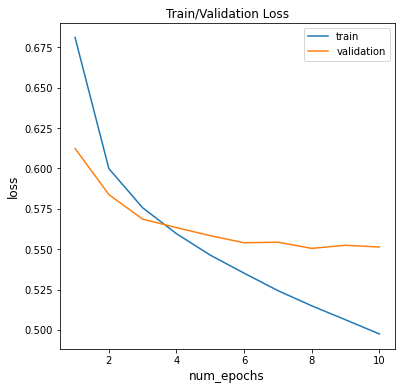

In [22]:
plot_graph(n_epochs)

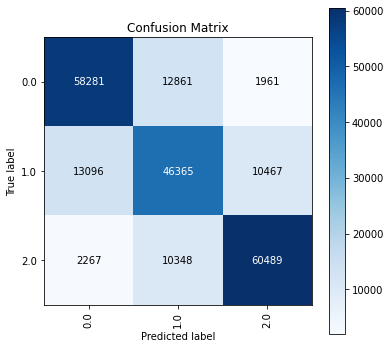

In [23]:
import scikitplot as skplt
y_true = [x for x in test_y]
y_pred = [x for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)
plt.savefig("conf_matrix_200k_withstopwords.png")

In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('F1: {}'.format(f1_score(y_true, y_pred, average = None)))
print('Precision: {}'.format(precision_score(y_true, y_pred, average = None)))
print('Recall: {}'.format(recall_score(y_true, y_pred, average = None)))
print(f'AUC: {roc_auc_score(y_true, val_preds, multi_class="ovr")}')

Accuracy: 0.7640363661600389
F1: [0.79430585 0.66472165 0.82849727]
Precision: [0.7913883  0.66641274 0.82955964]
Recall: [0.79724498 0.66303913 0.82743762]
AUC: 0.9111996780318151


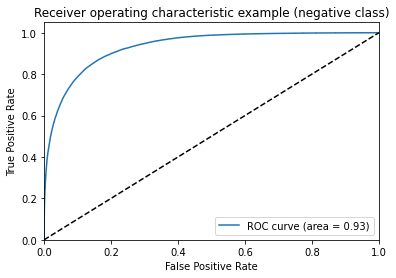

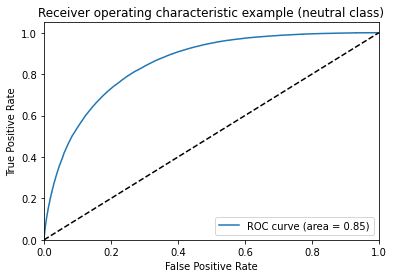

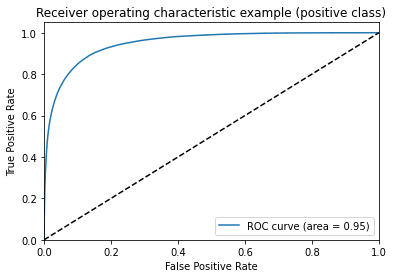

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# Creating OneHotEncoded labels for multiclasss plots
enc = OneHotEncoder(handle_unknown='ignore')
y_test = np.array(enc.fit_transform(np.array(y_true).reshape(-1, 1)).todense())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
classes = ['negative', 'neutral', 'positive']
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic example ({classes[i]} class)')
    plt.legend(loc="lower right")
    plt.savefig(f"auc_curves_withstopwords_{classes[i]}.png")